In [11]:
import yelp_api_bounds
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import api_import 
import simplejson as json

###Lemma of the Day: "80% of Restaurants Close within 5 years"
http://www.businessinsider.com/new-york-restaurants-fail-rate-2011-8 <br>
80% of Restaurants Close within 5 years - worth considering getting opening/closing data!<br>
http://www.thedailybeast.com/articles/2014/10/28/high-rents-are-killing-the-restaurant-capital.html

In [12]:
#Load master dataframe
df = pd.read_json("../data/census_zillow_subway_data.json")
df.set_index(['COUNTY_ID', 'TRACT_ID'],inplace=True,drop=True)

In [13]:
df.head(5)

ALAND  ALAND_SQMI   AWATER  AWATER_SQMI   BOROUGH  \
COUNTY_ID TRACT_ID                                                        
5         100       1672467       0.646  1032658        0.399     Bronx   
          200        455322       0.176   926899        0.358     Bronx   
          2702       157365       0.061        0        0.000     Bronx   
          16600      284801       0.110        0        0.000     Bronx   
47        93200      279758       0.108        0        0.000  Brooklyn   

                    FRAC_LAND        GEOID   INTPTLAT  INTPTLONG     LATMAX  \
COUNTY_ID TRACT_ID                                                            
5         100        0.618259  36005000100  40.793492 -73.883532  40.800898   
          200        0.329413  36005000200  40.803486 -73.860438  40.808779   
          2702       1.000000  36005002702  40.806437 -73.913737  40.808224   
          16600      1.000000  36005016600  40.829532 -73.830171  40.831935   
47        93200      1.000000  36047093200  40.637570 -73.929517  40.639951   

                           ...           \
COUNTY_ID TRACT_ID         ...            
5         100              ...            
          200              ...            
          2702             ...            
          16600            ...            
47        93200            ...            

                    unweighed_average_rating_restaurants_italian  \
COUNTY_ID TRACT_ID                                                 
5         100                                                NaN   
          200                                                NaN   
          2702                                               NaN   
          16600                                              NaN   
47        93200                                              NaN   

                    unweighed_average_rating_restaurants_japanese  \
COUNTY_ID TRACT_ID                                                  
5         100                                                 NaN   
          200                                                 NaN   
          2702                                                NaN   
          16600                                               NaN   
47        93200                                               NaN   

                    unweighed_average_rating_restaurants_latin  \
COUNTY_ID TRACT_ID                                               
5         100                                              NaN   
          200                                              NaN   
          2702                                             3.5   
          16600                                            NaN   
47        93200                                            NaN   

                   unweighed_average_rating_restaurants_mexican  \
COUNTY_ID TRACT_ID                                                
5         100                                               NaN   
          200                                               NaN   
          2702                                              NaN   
          16600                                             NaN   
47        93200                                             NaN   

                    unweighed_average_rating_restaurants_newamerican  \
COUNTY_ID TRACT_ID                                                     
5         100                                                    NaN   
          200                                                    NaN   
          2702                                                   NaN   
          16600                                                  NaN   
47        93200                                                  NaN   

                   unweighed_average_rating_restaurants_puertorican  \
COUNTY_ID TRACT_ID                                                    
5         100                                                   NaN   
          200               

In [14]:
df.columns

Index([u'ALAND', u'ALAND_SQMI', u'AWATER', u'AWATER_SQMI', u'BOROUGH', u'FRAC_LAND', u'GEOID', u'INTPTLAT', u'INTPTLONG', u'LATMAX', u'LATMIN', u'LONGMAX', u'LONGMIN', u'STATE', u'STATE_ID', u'STATION', u'STATION_DISTANCE', u'USPS', u'ZIPCODE', u'average_rating_restaurants_chinese', u'average_rating_restaurants_cuban', u'average_rating_restaurants_greek', u'average_rating_restaurants_indpak', u'average_rating_restaurants_italian', u'average_rating_restaurants_japanese', u'average_rating_restaurants_latin', u'average_rating_restaurants_mexican', u'average_rating_restaurants_newamerican', u'average_rating_restaurants_puertorican', u'average_rating_restaurants_tradamerican', u'average_rating_restaurants_vegetarian', u'closed_number_restaurants_chinese', u'closed_number_restaurants_cuban', u'closed_number_restaurants_greek', u'closed_number_restaurants_indpak', u'closed_number_restaurants_italian', u'closed_number_restaurants_japanese', u'closed_number_restaurants_latin', u'closed_number_r

##Looking for Restaurant Information from http://www.yelp.com/biz/
<p><strong>Within query_api, save the unique restaurant-id and then append that to yelp.com/biz/ !!!</strong> </p>

##Keys associated with each business from API call
u'is_claimed': <br>
u'rating'<br>
u'mobile_url'<br>
u'rating_img_url'<br>
u'review_count'<br>
u'name'<br>
u'rating_img_url_small'<br>
u'url'<br>
u'is_closed'<br>
u'snippet_text'<br>
u'categories'<br>
u'rating_img_url_large'<br>
u'id'<br>
u'snippet_image_url'<br>
u'location'

##Searching By Category
The yelp categories are found here: 
https://www.yelp.com/developers/documentation/v2/all_category_list

In [15]:
def yelp_restaurant_categories(country="All"):
    with open("../data/yelp/categories.dat","r") as f:
        content = [x.strip('\n') for x in f.readlines()]
    
    category_dict = {}

    for item in content:
        words = item.split(",")
        cuisine_type = words[0]  #no need for strip() for name
        cuisine_category = words[1].strip()
        cuisine_language_support = words[2:]
        cuisine_language_support = [x.strip() for x in cuisine_language_support]
        if (country in cuisine_language_support) | ("All" in cuisine_language_support):
            category_dict[cuisine_category] = [cuisine_type, cuisine_language_support]
        
    return category_dict

In [16]:
yelp_categories = yelp_restaurant_categories(country="US")

In [17]:
yelp_categories_usa = [{x: y[0]} for x,y in yelp_categories.items()]
print yelp_categories_usa[:5]

[{'mexican': 'Mexican'}, {'chinese': 'Chinese'}, {'german': 'German'}, {'moroccan': 'Moroccan'}, {'russian': 'Russian'}]


In [18]:
for category in yelp_categories_usa[0:5]:
    print category.keys()[0]," : ",category.values()[0]

mexican  :  Mexican
chinese  :  Chinese
german  :  German
moroccan  :  Moroccan
russian  :  Russian


##YELP api calls are done using *.py file not here

In [19]:
#yelp_dict = {}
#for category_cuisine in category_cuisine_list:
#    yelp_dict[category_cuisine] = {}
#    count = 0.0
#    for irow, row in df.head(30).iterrows():
#        lat_min = row['LATMIN']
#        lat_max = row['LATMAX']
#        long_min = row['LONGMIN']
#        long_max = row['LONGMAX']
#        bounds_str = "{0:<11.6f},{1:<11.6f}|{2:<11.6f},{3:<11.6f}".format(lat_min,long_max,lat_max,long_min) 
#        bounds_str = bounds_str.replace(" ","")
#        yelp_dict[category_cuisine][row.GEOID] = yelp_api_bounds.query_api("restaurant", category_cuisine, bounds_str)
#        count += 1
#        if np.mod(count,10.) == 0:
#            print count,'...'

##Import and Extract Info from Yelp API Queries

In [20]:
with open("../data/yelp/yelp_api_data.json", 'r') as fp:
    yelp_dict = json.load(fp)

category_cuisine_list = yelp_dict.keys()
category_cuisine_list = category_cuisine_list[:2]
print yelp_dict.keys()

['cafes', 'mexican', 'chinese', 'peruvian', 'ethiopian', 'japanese', 'tradamerican', 'spanish', 'newamerican', 'puertorican', 'soup', 'arabian', 'brazilian', 'korean', 'colombian', 'pizza', 'latin', 'french', 'diners', 'turkish', 'cuban', 'seafood', 'indpak', 'vegan', 'greek', 'mideastern', 'vegetarian', 'italian']


In [21]:
#Add restaurant numbers to DF
#First, add features based on types of restaurants to be queried.
for category_cuisine in category_cuisine_list:
    df['number_restaurants_'+category_cuisine] = 0.0
    df['average_rating_restaurants_'+category_cuisine] = np.nan
    df['unweighed_average_rating_restaurants_'+category_cuisine] = np.nan
    df['closed_number_restaurants_'+category_cuisine] = 0.0
df.head(5)

ALAND  ALAND_SQMI   AWATER  AWATER_SQMI   BOROUGH  \
COUNTY_ID TRACT_ID                                                        
5         100       1672467       0.646  1032658        0.399     Bronx   
          200        455322       0.176   926899        0.358     Bronx   
          2702       157365       0.061        0        0.000     Bronx   
          16600      284801       0.110        0        0.000     Bronx   
47        93200      279758       0.108        0        0.000  Brooklyn   

                    FRAC_LAND        GEOID   INTPTLAT  INTPTLONG     LATMAX  \
COUNTY_ID TRACT_ID                                                            
5         100        0.618259  36005000100  40.793492 -73.883532  40.800898   
          200        0.329413  36005000200  40.803486 -73.860438  40.808779   
          2702       1.000000  36005002702  40.806437 -73.913737  40.808224   
          16600      1.000000  36005016600  40.829532 -73.830171  40.831935   
47        93200      1.000000  36047093200  40.637570 -73.929517  40.639951   

                                 ...                 \
COUNTY_ID TRACT_ID               ...                  
5         100                    ...                  
          200                    ...                  
          2702                   ...                  
          16600                  ...                  
47        93200                  ...                  

                    unweighed_average_rating_restaurants_newamerican  \
COUNTY_ID TRACT_ID                                                     
5         100                                                    NaN   
          200                                                    NaN   
          2702                                                   NaN   
          16600                                                  NaN   
47        93200                                                  NaN   

                    unweighed_average_rating_restaurants_puertorican  \
COUNTY_ID TRACT_ID                                                     
5         100                                                    NaN   
          200                                                    NaN   
          2702                                                   NaN   
          16600                                                  NaN   
47        93200                                                  NaN   

                    unweighed_average_rating_restaurants_tradamerican  \
COUNTY_ID TRACT_ID                                                      
5         100                                                     NaN   
          200                                                     NaN   
          2702                                                    NaN   
          16600                                                   NaN   
47        93200                                                   NaN   

                   unweighed_average_rating_restaurants_vegetarian  \
COUNTY_ID TRACT_ID                                                   
5         100                                                  NaN   
          200                                                  NaN   
          2702                                                 NaN   
          16600                                                NaN   
47        93200                                                NaN   

                    zillow_house_index zillow_house_median  \
COUNTY_ID TRACT_ID                                           
5         100                        0                   0   
          200                        0                   0   
          2702                       0                   0   
          16600                      0                   0   
47        93200                      0                   0   

                    number_restaurants_cafes average_rating_restaurants_cafes  \
COUNTY_ID TRACT_ID         

In [7]:
category_cuisine_list

['cafes',
 'mexican',
 'chinese',
 'peruvian',
 'ethiopian',
 'japanese',
 'tradamerican',
 'spanish',
 'newamerican',
 'puertorican',
 'soup',
 'arabian',
 'brazilian',
 'korean',
 'colombian',
 'pizza',
 'latin',
 'french',
 'diners',
 'turkish',
 'cuban',
 'seafood',
 'indpak',
 'vegan',
 'greek',
 'mideastern',
 'vegetarian',
 'italian']

In [22]:
for category_cuisine in category_cuisine_list:
    print category_cuisine
    for (key,value) in yelp_dict[category_cuisine].items():
        scores = []
        weights = []
        closed_biz = 0.0
        open_biz = 0.0
        names_list = []
        ids_list = []
        scores_list = []
        review_count_list = []
        if len(value) > 0:
            for j in range(len(value)):
                if value[j]['is_closed'] == False:
                    #print "open!"
                    scores.append(float(value[j]['rating']))
                    weights.append(float(value[j]['review_count']))
                    names_list.append(value[j]['name'])
                    ids_list.append(value[j]['id'])
                    scores_list.append(str(value[j]['rating']))
                    review_count_list.append(str(value[j]['review_count']))
                    open_biz += 1
                elif value[j]['is_closed'] == True:
                    #print "closed!"
                    closed_biz += 1
            scores = np.array(scores)
            weights = np.array(weights)
            weighed_score = np.average(scores, weights = weights)
            unweighed_score = np.average(scores)
            if names_list != []:
                names_str = ";".join(names_list)
                ids_str = ";".join(ids_list)
                scores_str = ";".join(scores_list)
                review_count_str = ";".join(review_count_list)
            else:
                names_str = ""
                ids_str = ""
                scores_str = ""
                review_count_str = "" 
            #print key, open_biz, type(key), type(open_biz), type(df.ix[:,"GEOID"])
            df.loc[df["GEOID"].astype(str) == key,"number_restaurants_"+category_cuisine] = open_biz
            df.loc[df["GEOID"].astype(str) == key,"closed_number_restaurants_"+category_cuisine] = closed_biz
            df.loc[df["GEOID"].astype(str) == key,"average_rating_restaurants_"+category_cuisine] = weighed_score
            df.loc[df["GEOID"].astype(str) == key,"unweighed_average_rating_restaurants_"+category_cuisine] = unweighed_score
            
            df.loc[df["GEOID"].astype(str) == key,"restaurant_names_"+category_cuisine] = names_str
            df.loc[df["GEOID"].astype(str) == key,"restaurant_ids_"+category_cuisine] = ids_str
            df.loc[df["GEOID"].astype(str) == key,"restaurant_scores_"+category_cuisine] = scores_str
            df.loc[df["GEOID"].astype(str) == key,"restaurant_review_counts_"+category_cuisine] = review_count_str
            #print float(value[0]['rating']),float(value[0]['review_count'])

cafes
mexican


In [71]:
dfzip = df.groupby('ZIPCODE').mean()

In [72]:
dfzip

,ALAND,ALAND_SQMI,AWATER,AWATER_SQMI,FRAC_LAND,GEOID,INTPTLAT,INTPTLONG,LATMAX,LATMIN,...,unweighed_average_rating_restaurants_newamerican,unweighed_average_rating_restaurants_puertorican,unweighed_average_rating_restaurants_tradamerican,unweighed_average_rating_restaurants_vegetarian,zillow_house_index,zillow_house_median,number_restaurants_cafes,average_rating_restaurants_cafes,unweighed_average_rating_restaurants_cafes,closed_number_restaurants_cafes
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
0,1985246.600000,0.766500,25656474.800000,9.906000,0.488061,3.605472e+10,40.652365,-73.959278,40.670153,40.634578,...,3.348333,NaN,2.562778,3.600000,0,0,2.800000,3.419925,3.228333,0
10001,173119.000000,0.066500,0.000000,0.000000,1.000000,3.606101e+10,40.747402,-73.990328,40.749275,40.745528,...,3.854167,NaN,3.335714,4.125000,0,0,5.500000,3.107206,3.500000,0
10002,158703.923077,0.061308,96093.615385,0.037077,0.780163,3.606100e+10,40.715444,-73.984217,40.717589,40.713298,...,3.853595,NaN,3.729167,4.000000,0,0,1.076923,3.836934,3.890625,0
10003,137203.125000,0.053000,0.000000,0.000000,1.000000,3.606100e+10,40.730343,-73.989634,40.731992,40.728695,...,3.715625,NaN,3.543899,3.747619,0,0,2.125000,3.509979,3.366667,0
10004,450100.500000,0.173500,1648294.500000,0.636500,0.599749,3.606100e+10,40.690181,-74.032017,40.695381,40.684981,...,NaN,NaN,3.000000,NaN,0,0,0.000000,NaN,NaN,0
10005,336658.000000,0.130000,422042.000000,0.163000,0.443730,3.606100e+10,40.698676,-74.006157,40.702598,40.694754,...,5.000000,NaN,NaN,NaN,0,0,0.000000,NaN,NaN,0
10007,312722.000000,0.121000,0.000000,0.000000,1.000000,3.606100e+10,40.709109,-74.012980,40.711627,40.706591,...,3.500000,NaN,3.500000,4.000000,0,0,4.000000,2.092593,3.000000,0
10009,162527.400000,0.062700,107226.200000,0.041400,0.822632,3.606100e+10,40.724099,-73.977759,40.726223,40.721975,...,3.981685,4.25,3.789286,3.812500,0,0,1.200000,3.643740,3.298611,0
10010,162379.200000,0.062800,61850.600000,0.023800,0.857207,3.606101e+10,40.736977,-73.983480,40.739064,40.734891,...,3.364286,NaN,3.158482,4.312500,0,0,2.600000,3.552789,3.231250,0


In [2]:
df.plot(kind="scatter",x="median_owned",y="number_restaurants_japanese")

NameError: name 'df' is not defined

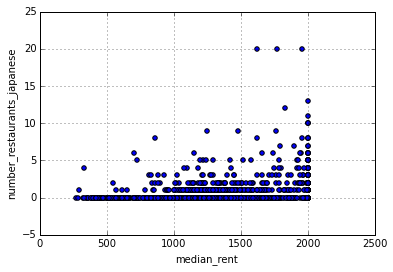

In [192]:
df.plot(kind="scatter",x="median_rent",y="number_restaurants_japanese")

In [193]:
df.loc[:,["ZIPCODE","INTPTLONG","INTPTLAT","number_restaurants_chinese","number_restaurants_mexican","average_rating_restaurants_mexican"]]

ZIPCODE  INTPTLONG   INTPTLAT  number_restaurants_chinese  \
COUNTY_ID TRACT_ID                                                              
5         100         11370 -73.883532  40.793492                           0   
          200         10473 -73.860438  40.803486                           0   
          400         10473 -73.850488  40.808915                           0   
          1600        10473 -73.858076  40.818848                           0   
          1900        10455 -73.909373  40.800999                           5   
          2000        10473 -73.866096  40.817580                           1   
          2300        10454 -73.925844  40.809082                           1   
          2400        10473 -73.871112  40.815753                           0   
          2500        10454 -73.920875  40.807003                           0   
          2701        10454 -73.916337  40.805064                           0   
          2702        10454 -73.913737  40.806437                           2   
          2800        10473 -73.878234  40.822518                           0   
          3100        10455 -73.905695  40.809876                           0   
          3300        10454 -73.911925  40.808223                           1   
          3500        10455 -73.908670  40.810965                           0   
          3700        10455 -73.912187  40.811442                           0   
          3800        10473 -73.863343  40.820295                           0   
          3900        10454 -73.921426  40.809722                           1   
          4001        10472 -73.858335  40.828272                           0   
          4100        10454 -73.919410  40.811386                           0   
          4200        10473 -73.862007  40.823931                           0   
          4300        10455 -73.917038  40.813621                           0   
          4400        10472 -73.866414  40.826515                           0   
          4600        10473 -73.869178  40.822419                           0   
          4800        10472 -73.874304  40.827017                           0   
          5001        10472 -73.877853  40.824997                           0   
          5002        10472 -73.878435  40.827363                           0   
          5100        10454 -73.927580  40.813206                           1   
          5200        10472 -73.882433  40.825629                           0   
          5300        10453 -73.922646  40.851434                           0   
...                     ...        ...        ...                         ...   
85        20801       10312 -74.209528  40.548656                           2   
          20803       10309 -74.210667  40.532820                           0   
          20804       10312 -74.199533  40.535804                           0   
          21300       10303 -74.138903  40.632616                           2   
          22300       10303 -74.151405  40.640901                           0   
          22600       10309 -74.230812  40.539521                           1   
          22800       10314 -74.186741  40.575224                           2   
          23100       10303 -74.156321  40.630124                           0   
          23900       10303 -74.149331  40.629540                           0   
          24401       10309 -74.238618  40.508673                           0   
          24402       10309 -74.238471  40.499787                           0   
          24700       10303 -74.141797  40.627509                           2   
          24800       10309 -74.243439  40.517492                           2   
          25100       10314 -74.146033  40.618041                           0   
          27301       10314 -74.152872  40.600080                           1   
          27302       10314 -74.138732  40.595558                           0   
          27702       10314 -74.163645  40.580089  

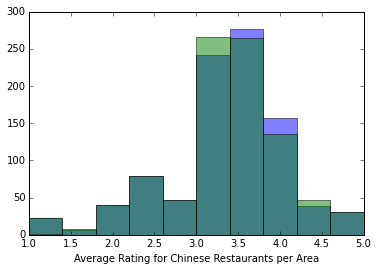

In [194]:
n, bins, patches = plt.hist(df[~np.isnan(df["average_rating_restaurants_chinese"])]["average_rating_restaurants_chinese"],alpha=0.5)
plt.hist(df[~np.isnan(df["unweighed_average_rating_restaurants_chinese"])]["unweighed_average_rating_restaurants_chinese"],bins=bins,alpha=0.5)
plt.xlabel("Average Rating for Chinese Restaurants per Area")

In [196]:
#Save dataframe
df.reset_index().to_json("../data/census_zillow_subway_time_yelp_data.json")

In [2]:
df.ZIPCODE

NameError: name 'df' is not defined

(2, 2)